In [1]:
import numpy as np
import pandas as pd
import torch
import yfinance as yf
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import datetime

%config InlineBackend.figure_format = 'retina'

In [295]:
df = yf.download("ETH-USD", period='max', interval="1d")
df.drop(['Adj Close'], axis=1, inplace=True)

[*********************100%%**********************]  1 of 1 completed


# Prepare data & Feature engineer

In [296]:
def feature_engineering(data, lags=8, spans=[7,10,25,50]):
    for w in spans:
        data[f'SMA_{w}'] = data['Close'].rolling(window=w).mean()
        data[f'EMA_{w}'] = data['Close'].ewm(span=w, adjust=False).mean()
        data[f'WMA_{w}'] = data['Close'].rolling(window=w).apply(lambda x: np.dot(x, np.arange(1, w+1)) / x.sum())
    data['Bollinger_Upper'] = data['Close'].rolling(window=20).mean() + (data['Close'].rolling(window=20).std() * 2)
    data['Bollinger_Lower'] = data['Close'].rolling(window=20).mean() - (data['Close'].rolling(window=20).std() * 2)
    data['ATR'] = data['High'].rolling(window=14).max() - data['Low'].rolling(window=14).min()
    data['RSI'] = 100 - (100 / (1 + data['Close'].diff(1).rolling(window=14).apply(lambda x: np.mean(x[x > 0]) / np.mean(-x[x < 0]) if np.mean(-x[x < 0]) != 0 else 0)))
    data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()
    data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

    # Lag features
    for lag in range(1, lags + 1):
        data[f'Lag_{lag}_Open'] = data['Open'].shift(lag)
        data[f'Lag_{lag}_High'] = data['High'].shift(lag)
        data[f'Lag_{lag}_Low'] = data['Low'].shift(lag)
        data[f'Lag_{lag}_Close'] = data['Close'].shift(lag)
        data[f'Lag_{lag}_Volume'] = data['Volume'].shift(lag)
    
    # Date features
    data['Day'] = data.index.day
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['DayOfWeek'] = data.index.dayofweek

    data.dropna(inplace=True)
    return data

In [297]:
df = feature_engineering(df)

In [5]:
X = df.drop(columns=['Open', 'High', 'Low', 'Close'])
y = df[['Open', 'High', 'Low', 'Close']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
# Scaling the data
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# XGBoost model

In [8]:
# XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# Predictions with XGBoost
xgb_predictions = xgb_model.predict(X_test_scaled)

# LSTM model

In [10]:
val_size = round(0.5 * X_test_scaled.shape[0])
X_val_lstm, X_test_lstm, y_val_lstm, y_test_lstm = torch.tensor(X_test_scaled[:val_size], dtype=torch.float32), torch.tensor(X_test_scaled[val_size:], dtype=torch.float32), torch.tensor(y_test_scaled[:val_size], dtype=torch.float32), torch.tensor(y_test_scaled[val_size:], dtype=torch.float32)

In [11]:
X_train_lstm = torch.tensor(X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1])), dtype=torch.float32)
X_val_lstm = X_val_lstm.reshape((X_val_lstm.shape[0], 1, X_val_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

In [12]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_lstm, torch.tensor(y_train_scaled, dtype=torch.float32))
valid_dataset = TensorDataset(X_val_lstm, y_val_lstm)
test_dataset = TensorDataset(X_test_lstm, y_test_lstm)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
from torch import nn
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

class LSTM_NN(pl.LightningModule):
    def __init__(self, input_size, output_size, hidden_layer_size=64, num_layers=2, lr=1e-3):
        super(LSTM_NN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.learning_rate = lr

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.linear_out = nn.Linear(hidden_layer_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.linear(hidden[-1])
        x = self.relu(x)
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear_out(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def fit(self, train_loader, valid_loader, max_epochs=1000):
        early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=True, mode='min')
        checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)
        trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[early_stop_callback, checkpoint_callback])
        trainer.fit(self, train_dataloaders=train_loader, val_dataloaders=valid_loader)
        
    def predict_future(self, recent_sequence, scaler, num_days=2):
        """Generate future predictions based on the recent sequence data

        Args:
            recent_sequence (torch.Tensor): Recent sequence data in tensor format
            scaler (sklearn.preprocessing.Scaler): An instance of the scaler used to scale the data with inverse_transform method
            num_days (int, optional): The number of days to predict into the future. Defaults to 2.

        Returns:
            Array: An array of future predictions
        """
        self.eval()
        recent_sequence_tensor = recent_sequence
        recent_sequence = recent_sequence.detach().numpy()
        future_predictions = []
        for _ in range(num_days):
            with torch.no_grad():
                predicted_scaled_price = self(recent_sequence_tensor)
            # predicted_price = scaler.inverse_transform(predicted_scaled_price.detach().numpy().reshape(1,-1))
            predicted_price = predicted_scaled_price.detach().numpy().reshape(1,-1)
            future_predictions.append(predicted_price)
            
            # Update the recent sequence by removing the first value and adding the new prediction
            new_sequence = np.append(recent_sequence[1:, :], [predicted_scaled_price], axis=0)
            recent_sequence_tensor = torch.tensor(new_sequence, dtype=torch.float32)

        return np.array(future_predictions).squeeze()

In [116]:
torch.manual_seed(42)
model = LSTM_NN(input_size=X_train_lstm.shape[-1], output_size=y_train_scaled.shape[-1], hidden_layer_size=64, num_layers=2).to('mps')
model.fit(train_loader, valid_loader, max_epochs=300)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | lstm       | LSTM   | 64.8 K | train
1 | linear     | Linear | 4.2 K  | train
2 | linear_out | Linear | 260    | train
3 | relu       | ReLU   | 0      | train
----------------------------------------------
69.2 K    Trainable params
0         Non-trainable params
69.2 K    Total params
0.277     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/pax/miniconda3/envs/price/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

/Users/pax/miniconda3/envs/price/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.272


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 0.077


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.


In [117]:
lstm_predictions = model(torch.cat([X_val_lstm, X_test_lstm], dim=0))
lstm_predictions = lstm_predictions.detach().numpy()

# Combine output

In [118]:
# Combine predictions
combined_predictions = 0.5 * xgb_predictions + 0.5 * lstm_predictions # give equal weight to both models
combined_predictions = scaler_y.inverse_transform(combined_predictions)

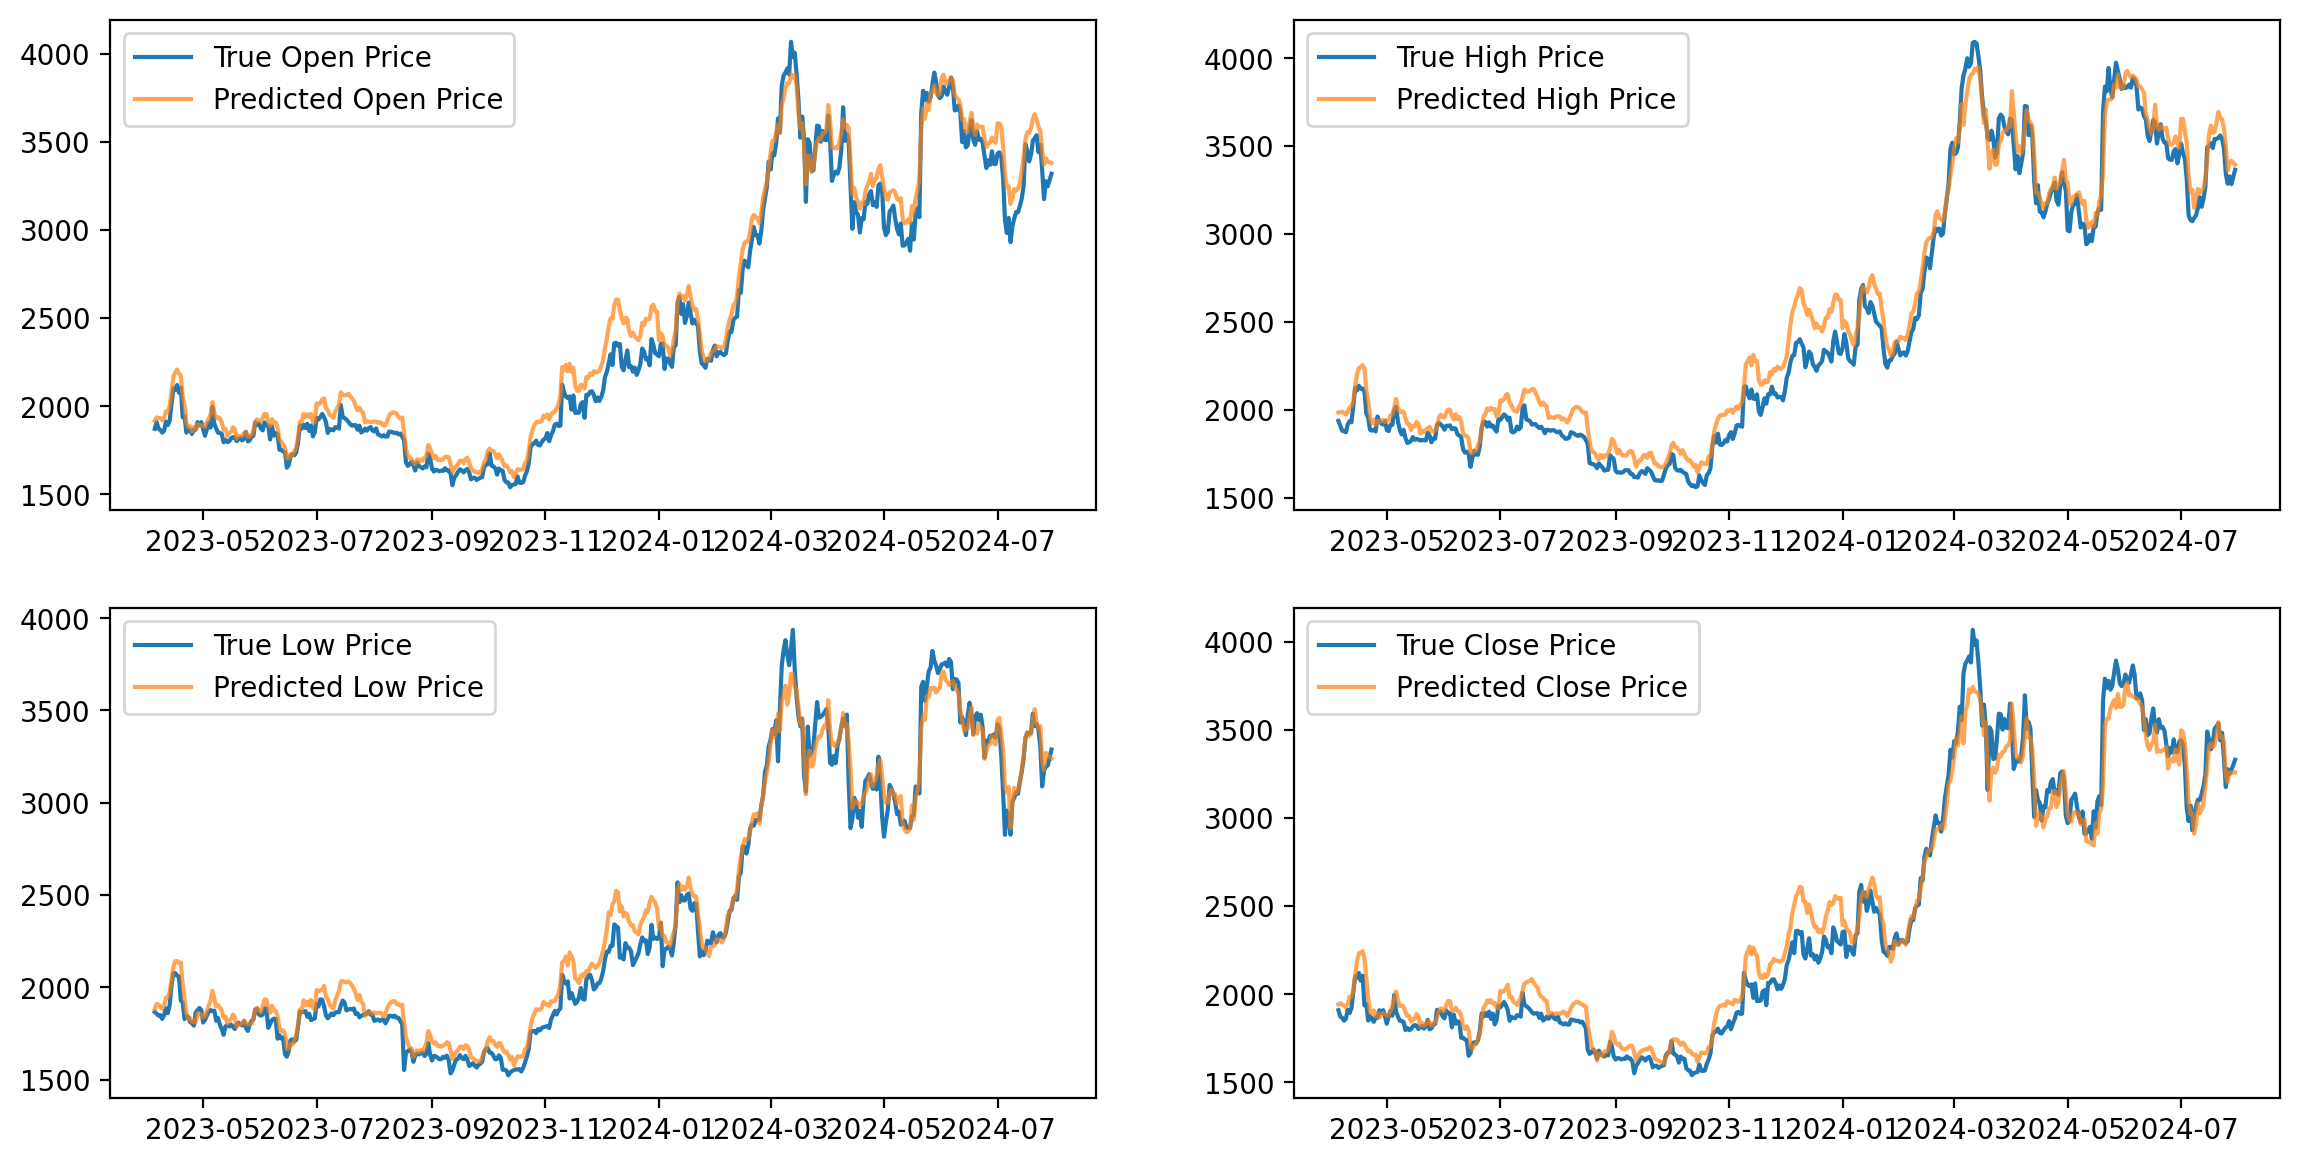

In [119]:
# Plot the results
plt.figure(figsize=(14, 7))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test.index, y_test[col].values, label='True ' + col + ' Price')
    plt.plot(y_test.index, combined_predictions[:, i], label='Predicted ' + col + ' Price', alpha=0.7)
    plt.legend()
plt.show()

In [120]:
pred_df = pd.DataFrame(combined_predictions, columns=['Open', 'High', 'Low', 'Close'], index=y_test.index)

In [121]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
                x = pred_df.index, # date values
                open = pred_df['Open'],
                high = pred_df['High'],
                low = pred_df['Low'],
                close = pred_df['Close'],
                increasing_line_color = 'green',
                decreasing_line_color = 'red')])

# Mask a default range slider
fig.update_layout(xaxis_rangeslider_visible=False)

# Set layout size
fig.update_layout(
    autosize=False,
    width=700,
    height=500)

In [122]:
pred_df['true_close'] = df.loc[y_test.index, 'Close']

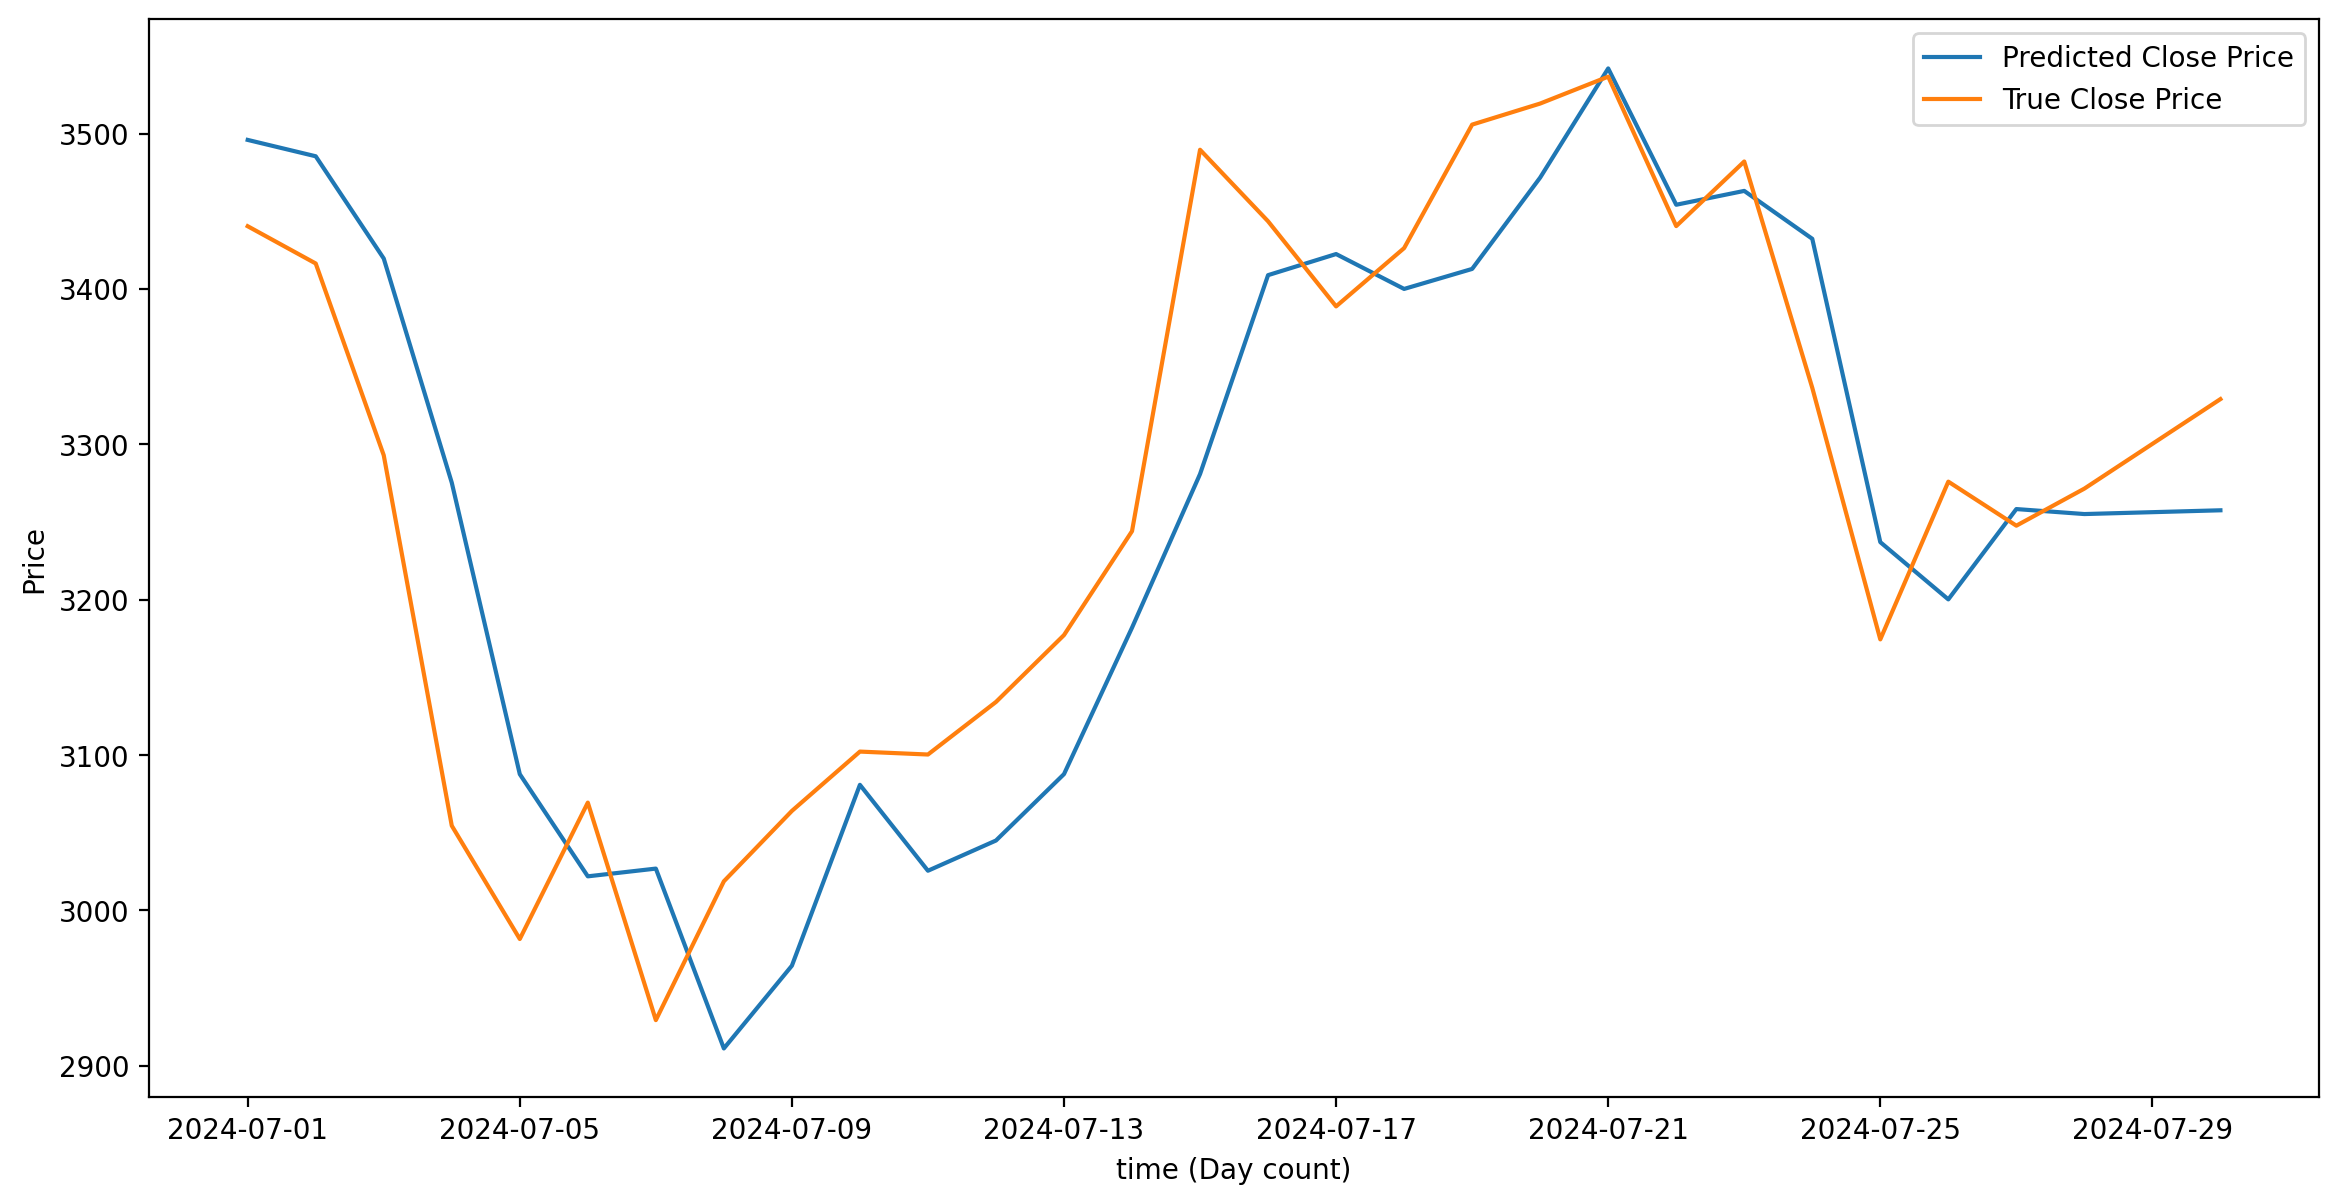

In [123]:
plt.figure(figsize=(14, 7))
plt.plot(pred_df['Close']['2024-07-1':], label='Predicted Close Price')
plt.plot(pred_df['true_close']['2024-07-1':], label='True Close Price')
plt.xlabel('time (Day count)')
plt.ylabel('Price')
plt.legend(loc='best')

# Predict future

In [58]:
from tqdm import tqdm
# Function to make future predictions
def predict_future(model_xgb, model_lstm, X_input, scaler, future_steps=10):
    future_predictions = []
    X_input_scaled = scaler.transform(X_input)
    
    for _ in range(future_steps):
        # XGBoost prediction
        xgb_pred = model_xgb.predict(X_input_scaled)
        
        # LSTM prediction
        lstm_input = X_input_scaled.reshape((X_input_scaled.shape[0], 1, X_input_scaled.shape[1]))
        lstm_pred = model_lstm(torch.tensor(lstm_input, dtype=torch.float32))
        lstm_pred = lstm_pred.detach().numpy()
        
        # Combine predictions
        combined_pred = 0.5 * xgb_pred + 0.5 * lstm_pred
        
        # Append to future predictions
        future_predictions.append(combined_pred.flatten())
        
        # Update X_input with the new prediction for the next step
        for i in tqdm(range(combined_pred.shape[0]), total=combined_pred.shape[0]):
            new_row_df = pd.DataFrame()
            new_row = combined_pred[i,:].flatten().tolist() + X_input.iloc[i, combined_pred.shape[-1]:].tolist()
            new_row_df = pd.concat([new_row_df, pd.DataFrame([new_row], columns=X_input.columns)], ignore_index=True)
        X_input = pd.concat([X_input.iloc[1:], new_row_df], ignore_index=True)
        X_input_scaled = scaler_x.transform(X_input)
        
    return np.array(future_predictions)

In [260]:
def predict_future(model_xgb, model_lstm, X_input, scaler, future_steps=10):
    future_predictions = []
    # X_input_scaled = scaler.transform(X_input)
    X_input_scaled = X_input
    size = X_input.shape[0]
    
    for _ in range(future_steps):
        # XGBoost prediction
        xgb_pred = model_xgb.predict(X_input_scaled[-1].reshape(1, -1))
        
        # LSTM prediction
        lstm_input = X_input_scaled.reshape((X_input_scaled.shape[0], 1, X_input_scaled.shape[1]))
        with torch.no_grad():
            lstm_pred = model_lstm(torch.tensor(lstm_input, dtype=torch.float32))
        lstm_pred = lstm_pred.detach().numpy()
        
        # Combine predictions
        combined_pred = 0.5 * xgb_pred + 0.5 * lstm_pred
        
        # Append to future predictions
        future_predictions.append(combined_pred[0])
        
        # Create new input for the next prediction step
        new_row = np.concatenate((combined_pred[:size], X_input[:size, 4:]), axis=1)
        new_row_df = pd.DataFrame(new_row)
        # X_input = np.concatenate([X_input[1:], new_row_df])
        # X_input_scaled = scaler.transform(X_input)
        X_input[0] = new_row_df.iloc[0]
        X_input_scaled = X_input
        
    return future_predictions

In [277]:
future_steps = 5
X_input = X_test_scaled[-10:].copy()  # Use the last few rows of the test set as the starting input
future_predictions = predict_future(xgb_model, model, X_input, future_steps=5, scaler=scaler_x)

In [278]:
future_predictions

[array([1.9969714, 1.9166393, 1.9716084, 1.8851306], dtype=float32),
 array([2.0173678, 1.9358786, 1.9908526, 1.9040706], dtype=float32),
 array([2.0180762, 1.9365488, 1.9915209, 1.9047284], dtype=float32),
 array([2.0181005, 1.9365718, 1.9915438, 1.9047511], dtype=float32),
 array([2.0181017, 1.9365727, 1.9915447, 1.904752 ], dtype=float32)]

In [279]:
np.array(future_predictions).shape

(5, 4)

In [280]:
future_predictions = scaler_y.inverse_transform(future_predictions)

In [281]:
# Assuming you have the last date of your training data
last_date = pd.Timestamp(datetime.datetime.today().date())

# Generate future dates
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, len(future_predictions) + 1)]

In [282]:
future_df = pd.DataFrame(future_predictions, columns=['Open', 'High', 'Low', 'Close'], index=future_dates)
future_df

,Open,High,Low,Close
2024-07-31,3512.612483,3523.304427,3360.866600,3380.898561
2024-08-01,3536.558903,3546.580597,3382.670809,3403.127405
2024-08-02,3537.390530,3547.391415,3383.427997,3403.899426
2024-08-03,3537.419081,3547.419250,3383.453930,3403.926009
2024-08-04,3537.420481,3547.420259,3383.455011,3403.927128


In [283]:
futute_df = pd.concat([pred_df, future_df], axis=0)

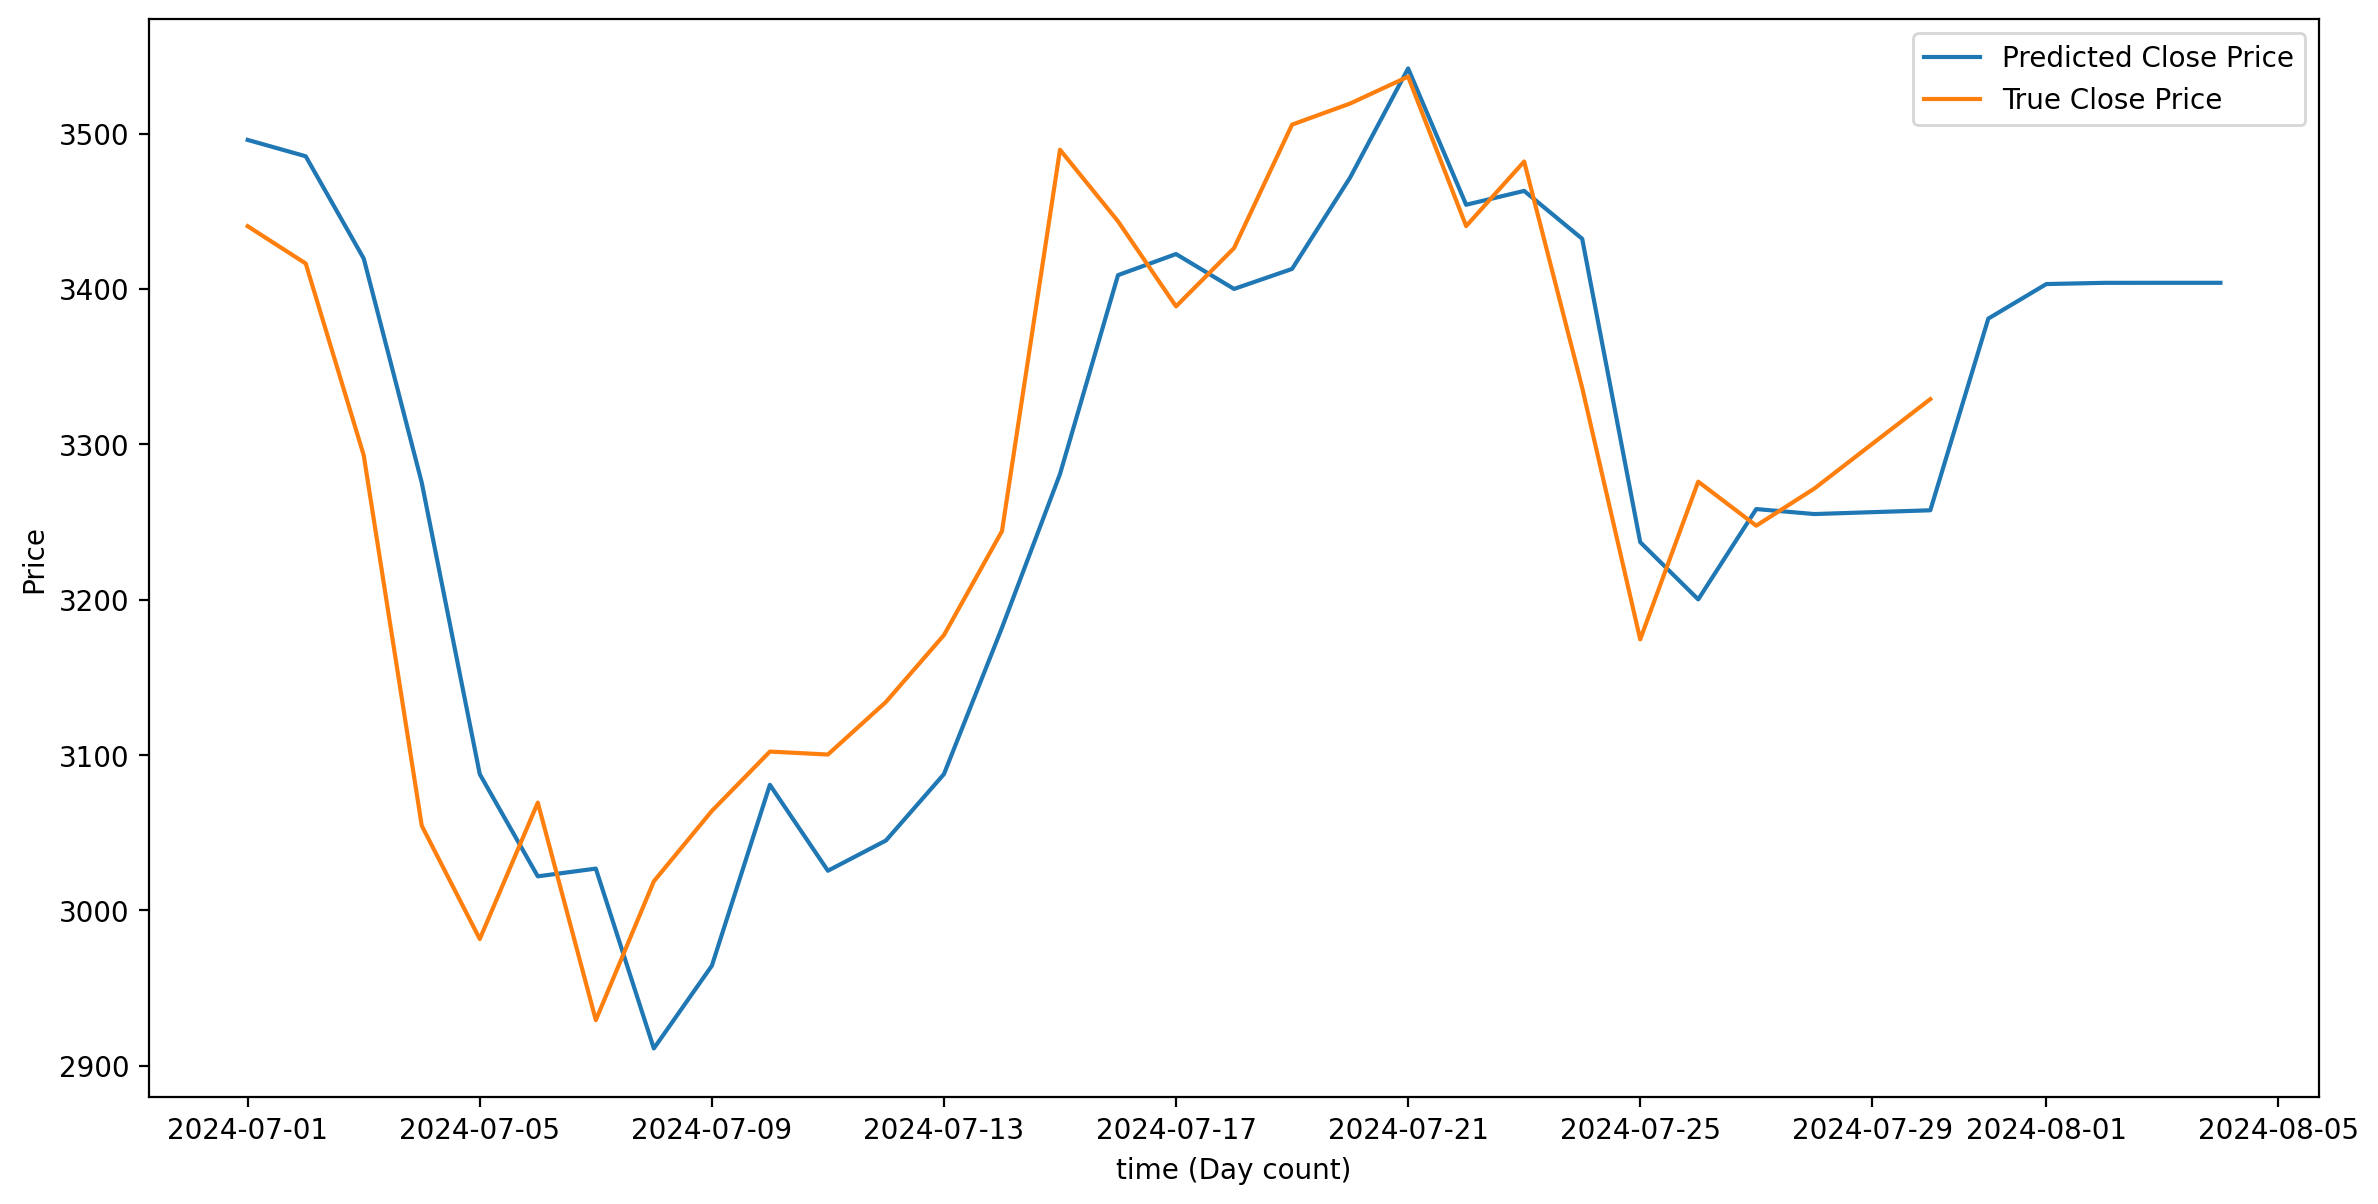

In [284]:
plt.figure(figsize=(14, 7))
plt.plot(futute_df['Close']['2024-07-1':], label='Predicted Close Price')
plt.plot(futute_df['true_close']['2024-07-1':], label='True Close Price')
plt.xlabel('time (Day count)')
plt.ylabel('Price')
plt.legend(loc='best')